<a href="https://colab.research.google.com/github/PhilipPfeffer/haptic_vest/blob/main/mobilenet_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrained MobileNet
MobileNet has been trained for many applications, including image segmentation, bounding box detection and ImageNet classification. In this notebook, we retrain the smallest version of MobileNet to classify whether an image in our dataset contains a 'person', a 'car' or 'neither.

# Acknowledgements
This was inspired by https://www.tensorflow.org/tutorials/images/transfer_learning (Accessed 29 Oct 2020).

# Code

## Imports
General Setup; GPU setup is under Training.

In [1]:
from numpy import loadtxt
import numpy as np
import os
import shutil
import math
import zipfile
import matplotlib.pyplot as plt
import itertools

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

import sklearn 
from sklearn import metrics
import tensorflow_addons as tfa


# Unzip Dataset

In [2]:
dataset_name = 'dataset_three'
zip_file_path = '/content/' + dataset_name + '.zip'
unzipped_dir = '/content'
dataset_X = '/content/' + dataset_name
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzipped_dir)

# Create Dataloader

In [21]:
BATCH_SIZE = 32
ORIG_IMG_SIZE = (96, 96)
ORIG_COLOR_MODE ='grayscale'
IMG_SIZE = (128,128)
COLOR_MODE = 'rgb'

train_dataset = image_dataset_from_directory(dataset_X +'/train/', label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
dev_dataset = image_dataset_from_directory(dataset_X +'/dev/', label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)
test_dataset = image_dataset_from_directory(dataset_X +'/test/', label_mode='categorical', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, color_mode=COLOR_MODE)

Found 65955 files belonging to 3 classes.
Found 9225 files belonging to 3 classes.
Found 4780 files belonging to 3 classes.


In [22]:
def show_example(train_dataset):
  for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = np.asarray(image[0]).squeeze()
    print(first_image.shape)
    # for i in range(9):
    #   ax = plt.subplot(3, 3, i + 1)
      # augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
      # plt.imshow(augmented_image[0] / 255)
    # print(image)
    plt.imshow(first_image / 255)
    plt.axis('off')
    
    break 

# Run with this line:
# show_example(train_dataset)

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
dev_dataset = dev_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# GPU Setup

In [24]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# MobileNet Model

In [25]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

In [26]:
# Loading model from https://www.tensorflow.org/lite/guide/hosted_models#image_classification

# Create the base model from the pre-trained model MobileNet
IMG_SHAPE = IMG_SIZE + (3,)

#Same syntax for MobileNetV2 and V1
mobilenet_version1 = True
base_model = None
if mobilenet_version1:
  base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                               alpha=0.25, # just add this
                                               include_top=False,
                                               weights='imagenet')
else:
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               alpha=0.35,#0.25, # just add this
                                               include_top=False,
                                               weights='imagenet')

In [27]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 256)


In [28]:
base_model.trainable = False
base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Model: "mobilenet_0.25_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 8)         216       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 8)         32        
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 8)         0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 8)         72        
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 8)  

## Data Augmentation
Add data augmentation to all images

In [88]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
# ])

In [30]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [64]:
def f1_score(num_classes):
  return tfa.metrics.F1Score(num_classes=num_classes, average="weighted")

In [65]:
num_classes = 3

In [33]:
base_learning_rate = 0.0005
# Compile model with accuracy and weighted F1 Score
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), metrics=['accuracy',  f1_score(num_classes)])

In [34]:
model.summary()
len(model.trainable_variables)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenet_0.25_128 (Function (None, 4, 4, 256)         218544    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

2

# Training (Stage 1: Frozen)

In [35]:
initial_epochs = 20

loss0, accuracy0, f1_score0 = model.evaluate(dev_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial f1_score: {:.2f}".format(f1_score0))

289/289 [==============================] - 7s 23ms/step - loss: 3.0512 - accuracy: 0.2870 - f1_score: 0.1466
initial loss: 3.05
initial accuracy: 0.29
initial f1_score: 0.15


In [36]:
# Configure eary stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [37]:
# with tf.device('/device:GPU:0'):
history = model.fit(train_dataset,
                epochs=initial_epochs,
                validation_data=dev_dataset,
                callbacks=[early_stopping])

Epoch 1/20
2062/2062 [==============================] - 55s 26ms/step - loss: 0.5129 - accuracy: 0.7814 - f1_score: 0.7809 - val_loss: 0.3395 - val_accuracy: 0.8568 - val_f1_score: 0.8572
Epoch 2/20
2062/2062 [==============================] - 57s 28ms/step - loss: 0.3775 - accuracy: 0.8365 - f1_score: 0.8357 - val_loss: 0.3243 - val_accuracy: 0.8593 - val_f1_score: 0.8589
Epoch 3/20
2062/2062 [==============================] - 58s 28ms/step - loss: 0.3708 - accuracy: 0.8381 - f1_score: 0.8373 - val_loss: 0.3216 - val_accuracy: 0.8610 - val_f1_score: 0.8608
Epoch 4/20
2062/2062 [==============================] - 58s 28ms/step - loss: 0.3688 - accuracy: 0.8378 - f1_score: 0.8370 - val_loss: 0.3223 - val_accuracy: 0.8618 - val_f1_score: 0.8615
Epoch 5/20
2062/2062 [==============================] - 58s 28ms/step - loss: 0.3682 - accuracy: 0.8377 - f1_score: 0.8368 - val_loss: 0.3202 - val_accuracy: 0.8624 - val_f1_score: 0.8615
Epoch 6/20
2062/2062 [==============================] - 58s 

In [38]:
model.save('/content/three_model_stage1_aug')

save_to_drive=True
if save_to_drive:
  model.save('/content/drive/My Drive/Haptic Vest/three_model_stage1_aug')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/three_model_stage1_aug/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Haptic Vest/three_model_stage1_aug/assets


# Learning Plot

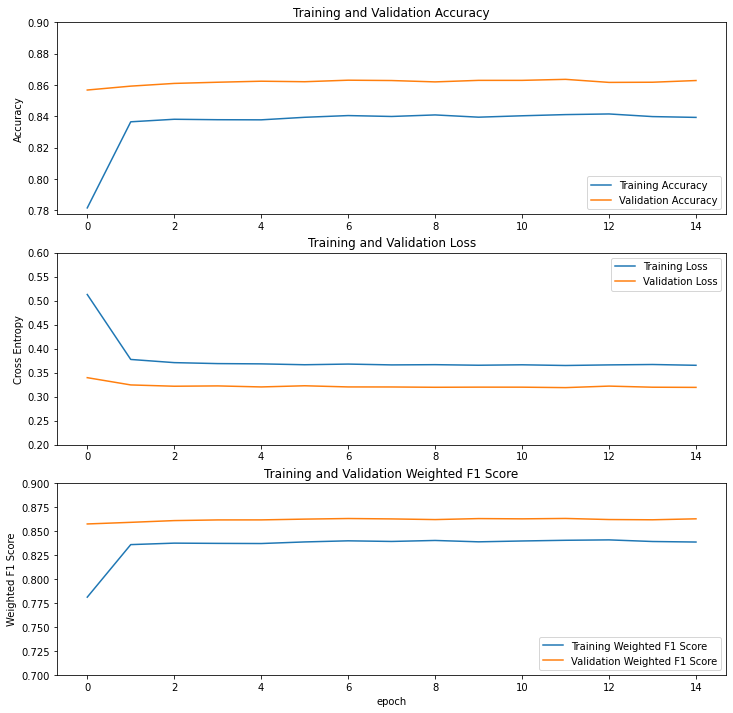

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


f1_score_hist = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.9])
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.2,0.6])
plt.title('Training and Validation Loss')

plt.subplot(3, 1, 3)
plt.plot(f1_score_hist, label='Training Weighted F1 Score')
plt.plot(val_f1_score, label='Validation Weighted F1 Score')
plt.legend(loc='lower right')
plt.ylabel('Weighted F1 Score')
plt.ylim([0.7,0.9])
plt.title('Training and Validation Weighted F1 Score')
plt.xlabel('epoch')
plt.show()

From GOOGLE
Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

# Training (Stage 2: Unfrozen)

In [61]:
base_model.trainable = True

In [62]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  87


In [66]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10), metrics=['accuracy', f1_score(num_classes)])
# model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), metrics=['accuracy',  f1_score(num_classes)])


model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenet_0.25_128 (Function (None, 4, 4, 256)         218544    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [67]:
len(model.trainable_variables)

2

### Continue training the model

In [68]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=dev_dataset, 
                         callbacks=[early_stopping])

Epoch 15/30
2062/2062 [==============================] - 54s 26ms/step - loss: 0.3642 - accuracy: 0.8411 - f1_score: 0.8403 - val_loss: 0.3183 - val_accuracy: 0.8651 - val_f1_score: 0.8647
Epoch 16/30
2062/2062 [==============================] - 57s 28ms/step - loss: 0.3632 - accuracy: 0.8425 - f1_score: 0.8416 - val_loss: 0.3186 - val_accuracy: 0.8651 - val_f1_score: 0.8646
Epoch 17/30
2062/2062 [==============================] - 59s 29ms/step - loss: 0.3597 - accuracy: 0.8425 - f1_score: 0.8417 - val_loss: 0.3184 - val_accuracy: 0.8649 - val_f1_score: 0.8643
Epoch 18/30
2062/2062 [==============================] - 59s 29ms/step - loss: 0.3608 - accuracy: 0.8436 - f1_score: 0.8428 - val_loss: 0.3193 - val_accuracy: 0.8645 - val_f1_score: 0.8640


In [70]:
model.save('/content/three_model_stage2_aug')

save_to_drive=True
if save_to_drive:
  model.save('/content/drive/My Drive/Haptic Vest/three_model_stage2_aug')

INFO:tensorflow:Assets written to: /content/three_model_stage2_aug/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Haptic Vest/three_model_stage2_aug/assets


In [72]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

f1_score_hist += history_fine.history['f1_score']
val_f1_score += history_fine.history['val_f1_score']

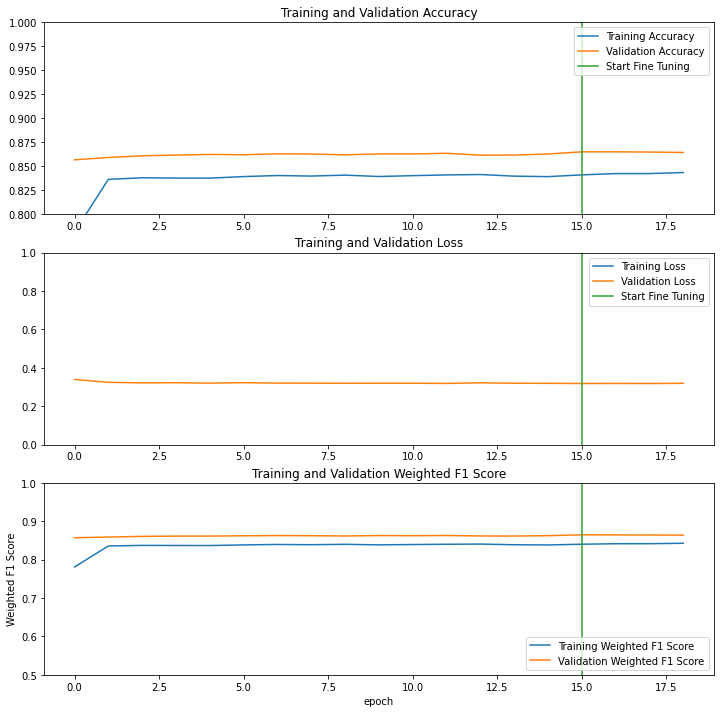

In [85]:
end_stage1 = 16
end_stage2 = 18
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([end_stage1-1,end_stage1-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([end_stage1-1,end_stage1-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(3, 1, 3)
plt.plot(f1_score_hist, label='Training Weighted F1 Score')
plt.plot(val_f1_score, label='Validation Weighted F1 Score')
plt.legend(loc='lower right')
plt.ylabel('Weighted F1 Score')
plt.ylim([0.5,1.0])
plt.plot([end_stage1-1,end_stage1-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Weighted F1 Score')
plt.xlabel('epoch')
plt.show()

# Load Model

In [74]:
# load_model_path='/content/three_model_stage1'
# load_model_path='/content/three_model_stage2'
# three_model_stage1_aug
load_model_path = '/content/drive/My Drive/Haptic Vest/three_model_stage2_aug'
loaded_model = keras.models.load_model(load_model_path, custom_objects={'F1Score': tfa.metrics.F1Score})

# Evaluation and prediction

In [75]:
loss, accuracy, f1_score = loaded_model.evaluate(train_dataset)
print('Train accuracy :', accuracy)
print('Train F1 Score :', f1_score)

loss, accuracy, f1_score = loaded_model.evaluate(dev_dataset)
print('Dev accuracy :', accuracy)
print('Dev F1 Score :', f1_score)

2062/2062 [==============================] - 48s 23ms/step - loss: 0.3357 - accuracy: 0.8541 - f1_score: 0.8532
Train accuracy : 0.8540823459625244
Train F1 Score : 0.8531746864318848
289/289 [==============================] - 7s 24ms/step - loss: 0.3193 - accuracy: 0.8645 - f1_score: 0.8640
Dev accuracy : 0.8644986152648926
Dev F1 Score : 0.8640004992485046


In [76]:
loss, accuracy, f1_score = loaded_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print('Test F1 Score :', f1_score)

150/150 [==============================] - 4s 24ms/step - loss: 0.2998 - accuracy: 0.8672 - f1_score: 0.8665
Test accuracy : 0.8671548366546631
Test F1 Score : 0.8665369153022766


In [ ]:
# # Define classes
# classes = ['neither', 'person', None , 'car']

# #Retrieve a batch of images from the test set
# image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch).flatten()

# # Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

# # print('Predictions:\n', predictions.numpy())
# # print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(classes[predictions[i]])
#   plt.axis("off")

# Incorrect Predictions: Confusion Matrix & Highest Losses

In [77]:
def to_one_hot(class_id_pre):
  class_idx_test = class_id_pre if class_id_pre < 2 else 2
  one_hot = [0,0,0]
  one_hot[class_idx_test] = 1
  return one_hot

to_one_hot(3)

[0, 0, 1]

In [78]:
incorrect_predictions = []

In [79]:
confusion_matrix = np.zeros((3,3), dtype=int)

# for entry in os.scandir(dataset_X):
class_ids = [0,1,3]
counter = 0
bad_counter = 0
for class_id in class_ids:
  base_test_path = '/content/dataset_three/dev/' + str(class_id) + '/'
  for entry in os.scandir(base_test_path):
    try:
      test_img = keras.preprocessing.image.load_img(entry.path, target_size=IMG_SIZE)
      img_array = keras.preprocessing.image.img_to_array(test_img)
      img_array = tf.expand_dims(img_array, 0)  # Create batch axis
      predictions = loaded_model.predict(img_array)
      score = predictions[0]
      class_pred = class_ids[np.argmax(score)]
      # print(f"Actual | Prediction: {class_id} | {class_pred}")
      class_id_idx = class_id if class_id < 2 else 2
      class_pred_idx = class_pred if class_pred < 2 else 2
      if class_id != class_pred:
        # print(f"WRONG: {os.path.basename(entry)}.\nActual/Pred: {class_id} | {class_pred}")
        loss = tf.keras.losses.categorical_crossentropy(to_one_hot(class_id), score)
        incorrect_predictions.append((float(loss), entry.path, class_id, class_pred))
      confusion_matrix[class_id_idx][class_pred_idx] += 1
    except:
      print(f'BAD FILE: {entry.path}')
      bad_counter +=1
      if bad_counter == len(class_ids)+1:  # in case there's a problem, this should break the loop (but ignore the .DS_Store files)
        assert False

    if counter % 1000 == 0:
      print(f"{counter} images processed")
    counter += 1


print(confusion_matrix)

0 images processed
1000 images processed
BAD FILE: /content/dataset_three/dev/0/.DS_Store
2000 images processed
3000 images processed
4000 images processed
5000 images processed
BAD FILE: /content/dataset_three/dev/1/.DS_Store
6000 images processed
7000 images processed
BAD FILE: /content/dataset_three/dev/3/.DS_Store
8000 images processed
9000 images processed
[[3369  496   21]
 [ 638 2029    3]
 [ 139   11 2519]]


In [80]:
saved_confusion = confusion_matrix
print(saved_confusion)

[[3369  496   21]
 [ 638 2029    3]
 [ 139   11 2519]]


Text(0.5, -8.234018715767732, 'Predicted label')

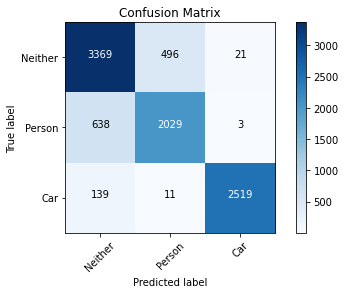

In [81]:
classes = ['Neither', 'Person', 'Car']
cm = saved_confusion
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [82]:
def get_k_worst_preds(k, preds):
  return sorted(preds, key=lambda elem: float(elem[0]), reverse=True)[:k]

print(get_k_worst_preds(9, incorrect_predictions))

[(9.88139533996582, '/content/dataset_three/dev/3/cartest_02572.jpg', 3, 1), (9.718024253845215, '/content/dataset_three/dev/1/000000171539.jpg', 1, 3), (8.618617057800293, '/content/dataset_three/dev/3/cartest_02835.jpg', 3, 0), (8.263154983520508, '/content/dataset_three/dev/3/cartrain_06775.jpg', 3, 0), (7.442458629608154, '/content/dataset_three/dev/3/cartrain_05325.jpg', 3, 0), (6.972815036773682, '/content/dataset_three/dev/0/000000116652.jpg', 0, 3), (6.816265106201172, '/content/dataset_three/dev/3/cartest_02758.jpg', 3, 0), (6.698837757110596, '/content/dataset_three/dev/3/cartrain_05520.jpg', 3, 1), (6.399153232574463, '/content/dataset_three/dev/3/cartest_07796.jpg', 3, 0)]


In [83]:
def non_car_sorter(elem):
  if elem[2] != 3 and elem[3] != 3:
    return float(elem[0])
  return 0

def get_k_worst_non_car_preds(k, preds):
  return sorted(preds, key=non_car_sorter, reverse=True)[:k]

print(get_k_worst_non_car_preds(9, incorrect_predictions))

[(5.13815450668335, '/content/dataset_three/dev/1/000000493610.jpg', 1, 0), (4.485766887664795, '/content/dataset_three/dev/1/000000250953.jpg', 1, 0), (4.1216912269592285, '/content/dataset_three/dev/1/000000318231.jpg', 1, 0), (4.082488059997559, '/content/dataset_three/dev/0/000000554084.jpg', 0, 1), (3.9915874004364014, '/content/dataset_three/dev/1/000000562906.jpg', 1, 0), (3.978821277618408, '/content/dataset_three/dev/1/000000246016.jpg', 1, 0), (3.9603829383850098, '/content/dataset_three/dev/1/000000063140.jpg', 1, 0), (3.9464473724365234, '/content/dataset_three/dev/1/000000317998.jpg', 1, 0), (3.9415390491485596, '/content/dataset_three/dev/1/000000113721.jpg', 1, 0)]


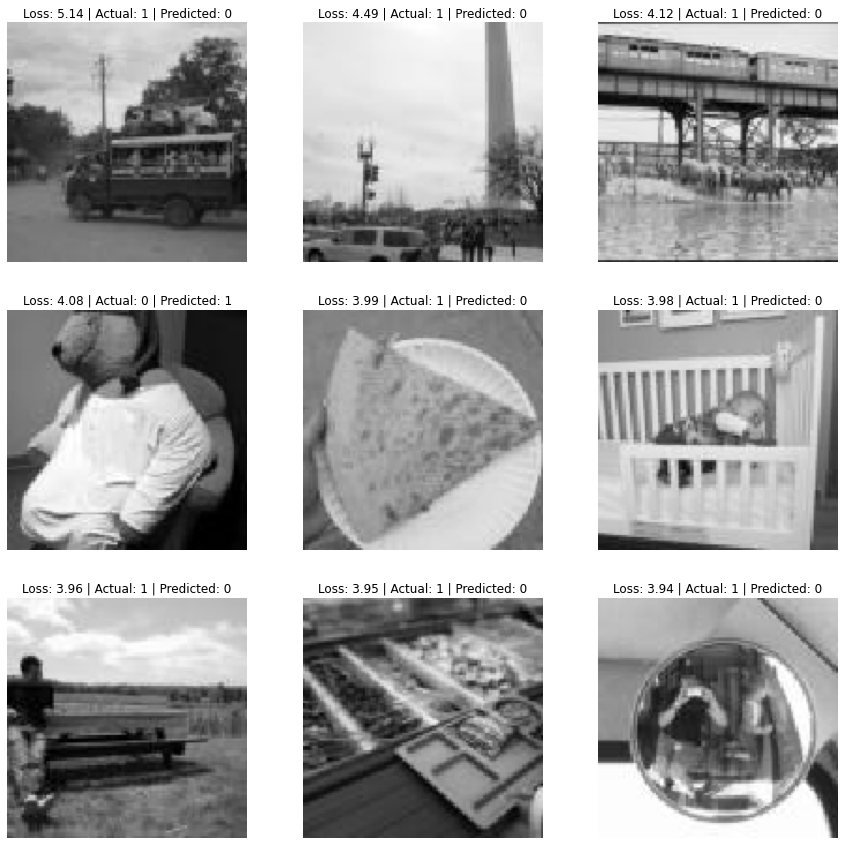

In [87]:
# for i in range(9):
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(classes[predictions[i]])

plt.figure(figsize=(15, 15))
num_incorrect_display = 9
display_idx = 0
loss_display_function = get_k_worst_non_car_preds
# loss_display_function = get_k_worst_preds
for loss, incorrect_path, incorrect_actual, incorrect_pred in loss_display_function(num_incorrect_display, incorrect_predictions):
  display_idx += 1
  loss_rounded = np.round_(float(loss),2)
  incorrect_img = keras.preprocessing.image.load_img(incorrect_path, target_size=IMG_SIZE)
  incorrect_img_array = keras.preprocessing.image.img_to_array(incorrect_img)
  ax = plt.subplot(3, 3, display_idx)
  # plt.figure()
  plt.axis("off")
  plt.title(f"Loss: {loss_rounded} | Actual: {incorrect_actual} | Predicted: {incorrect_pred}") #\n{incorrect_path}
  plt.imshow(incorrect_img_array.astype("uint8"))

# Microcontroller (Arduino)

## Convert the model to tflite

In [54]:
# NORMAL UNQUANTISED
# Convert
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save
with open('mobilenetv2.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp9jfkb6ki/assets


INFO:tensorflow:Assets written to: /tmp/tmp9jfkb6ki/assets


(128, 128, 3)


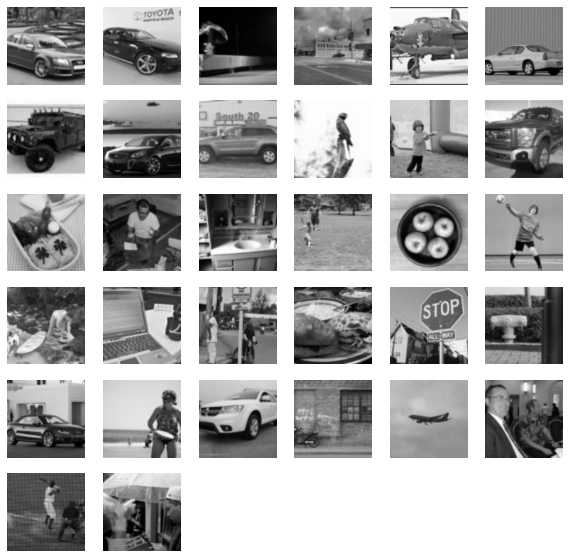

In [90]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  print(images[0].numpy().shape)
  for i in range(32):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

NOTE: If you run this, you have to rerun the cell that creates the dataloader and NOT run the prefetching cell.

In [89]:
# !pip install tf-nightly

In [6]:
# UINT8 Quantised
def representative_data_gen():
  for images, labels in train_dataset.take(1):
    for i in range(32):
      yield [tf.expand_dims(images[i], 0)]

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

# Save
with open('mobilenetv2_quant.tflite', 'wb') as f:
  f.write(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmp6znx_r36/assets


INFO:tensorflow:Assets written to: /tmp/tmp6znx_r36/assets


## Convert tflite to C++

In [20]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
# !xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
!xxd -i base_model.tflite > base_model.cc
# Update variable names
# REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
# !sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


In [ ]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}